# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека.

## Исследовательский анализ данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.stats import gaussian_kde
import numpy as np

labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [2]:
labels.shape

(7591, 2)

Для построения модели, нам были предоставлены данные с 7591 изображениями людей с указанным возрастом.

In [62]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


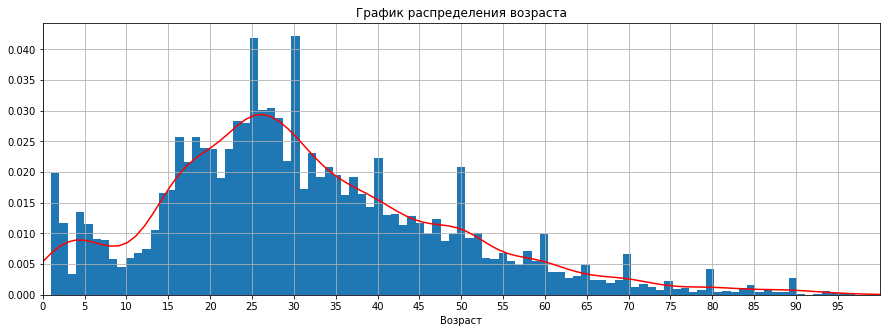

In [4]:
plt.xticks([i for i in range(0, 100, 5)])
plt.xlabel('Возраст')
plt.title('График распределения возраста')
plt.xlim(0, 100)

labels['real_age'].hist(bins=100, figsize=(15, 5), density=True)

density = gaussian_kde(labels['real_age'])
x = np.linspace(0, 100, 100)
y = density(x)
plt.plot(x, y, 'r')


plt.show()

Среднее значение возраста людей в предоставленных данных составляет 31 год. Для объективного анализа, мы могли бы отбросить данные с крайними значениями: возрастом до 5 лет, так как они не соответствуют целевой категории исследования - покупатели. Однако оставим данные как есть, так как это не помешает для текущего этапа исследования.

Рассмотрим предоставленные изображения.

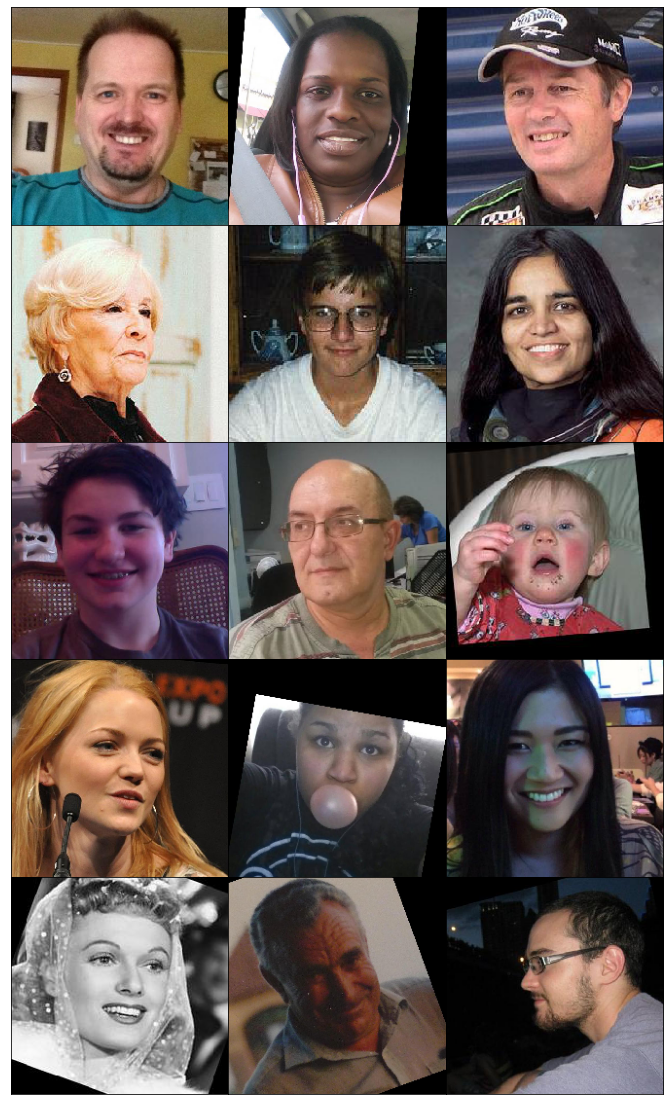

In [63]:
fig, ax = plt.subplots(5, 3)
fig.set_size_inches(11.7, 20)
fig.subplots_adjust(wspace=0, hspace=0)
for i in range(1, 16):
    plt.subplot(5, 3, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_gen_flow[0][0][i - 1])

Нам предоставленны фотографии разного качества. Лица людей сняты с разных ракурсов. Имеются фотографии в черно-белом формате, общая ориентация фотографий примерно одинакова, начальный размер изображений отличается, в силу того, что визуально заметно различное качество фото, где-то есть черные рамки (они не несут полезной информации). Размер изображений мы приведем к единому перед обучением модели.

## Обучение модели

(Код в этом разделе запускается в отдельном сервере, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
import pandas as pd

 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=0.2,
        height_shift_range=0.2
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=(150, 150, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae']) 
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=3, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              batch_size=batch_size, 
              epochs=epochs, 
              verbose=2)
    return model 

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 127s - loss: 267.5496 - mae: 11.9019 - val_loss: 642.2059 - val_mae: 20.2609
Epoch 2/10
356/356 - 104s - loss: 126.0719 - mae: 8.5439 - val_loss: 287.0125 - val_mae: 13.1049
Epoch 3/10
356/356 - 106s - loss: 105.5274 - mae: 7.8413 - val_loss: 108.7196 - val_mae: 7.8983

```

## Анализ обученной модели

Задачей данного исследования являлось создание модели, способной определять возраст клиентов, для того чтобы: анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, контролировать добросовестность кассиров при продаже алкоголя. 

В качестве данных для обучения, нам было предоставлено 7591 фотографий людей с указанным возрастом. Среднее значение возраста людей составил 31 год. Для объективного анализа, мы могли бы отбросить данные с крайними значениями: возрастом до 5 лет, так как они не соответствуют целевой категории исследования - покупатели. Однако мы решили оставить данные как есть.

В конечном счете нам удалось построить модель основанную на популярной архитектуре сверточных нейросетей ResNet, способную определять возраст человека со значением ошибки в пределах 8 лет.